In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report, make_scorer

In [2]:
df = pd.read_csv('../Data/daily_fitbit_sema_df_unprocessed.csv')

In [3]:
df

,Unnamed: 0,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,0,621e2e8e67b776a24055b564,5/24/21,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,621e2e8e67b776a24055b564,5/25/21,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,621e2e8e67b776a24055b564,5/26/21,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,621e2e8e67b776a24055b564,5/27/21,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4,621e2e8e67b776a24055b564,5/28/21,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,7405,621e362467b776a2404ad513,5/18/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7406,7406,621e36f967b776a240e5e7c9,5/20/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7407,7407,621e362467b776a2404ad513,5/23/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7408,7408,621e339967b776a240e502de,11/19/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# because there are so many features, dropping columns is inefficient, so make new df with the features we want
features_df = df[[
    'calories', 
    'distance',
    'steps',
    'age',
    'stress_score',
    'lightly_active_minutes', 
    'moderately_active_minutes', 
    'very_active_minutes', 
    'sedentary_minutes', 
    'gender', 
    'bmi', 
    'sleep_points_percentage'
]]

features_df

,calories,distance,steps,age,stress_score,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,gender,bmi,sleep_points_percentage
0,2351.59,6517.5,8833.0,<30,78.0,149.0,24.0,33.0,713.0,MALE,<19,0.833333
1,2332.08,7178.6,9727.0,<30,80.0,132.0,25.0,31.0,704.0,MALE,<19,0.833333
2,2262.30,6090.9,8253.0,<30,84.0,112.0,27.0,31.0,710.0,MALE,<19,0.966667
3,2325.10,6653.1,9015.0,<30,82.0,133.0,21.0,37.0,622.0,MALE,<19,0.933333
4,2586.76,9557.9,12949.0,<30,81.0,136.0,42.0,54.0,647.0,MALE,<19,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...
7405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropped features ['steps', 'sleep_points_percentage']


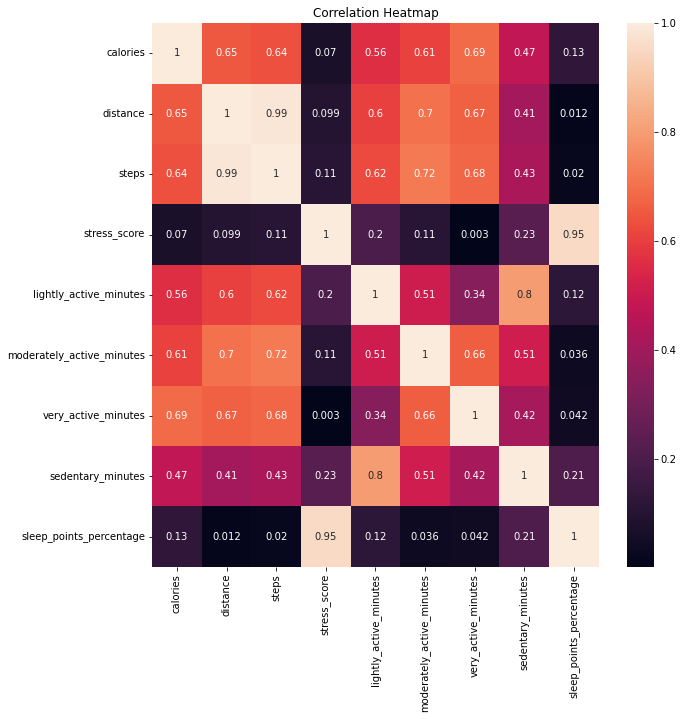

In [5]:
plt.figure(figsize=(10,10))
corr = features_df.corr().abs()
sns.heatmap(corr, annot=True).set_title("Correlation Heatmap")
corr_matrix = features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
print("Dropped features", to_drop)

In [6]:
#Since steps and distance and stress_score and sleep_points_percentage are highly correlated. Keeping both pairs of correlated
#features means keeping redundant information.
features_df=features_df.drop(['distance','stress_score'],axis=1)
features_df.shape

(7410, 10)

In [7]:
print(features_df.isnull().sum())

calories                      750
steps                        2633
age                           614
lightly_active_minutes        327
moderately_active_minutes     327
very_active_minutes           327
sedentary_minutes             327
gender                        370
bmi                           614
sleep_points_percentage      5534
dtype: int64


In [8]:
# removing rows from features_df if there are less than 3 features with missing values
features_df = features_df[features_df.isnull().sum(axis=1) < 3]
features_df.shape

(6104, 10)

In [9]:
print(features_df.isnull().sum())

calories                        0
steps                        1804
age                             0
lightly_active_minutes          0
moderately_active_minutes       0
very_active_minutes             0
sedentary_minutes               0
gender                          0
bmi                             0
sleep_points_percentage      4278
dtype: int64


In [10]:
features_df=features_df.dropna(subset=['sleep_points_percentage'])
print(features_df.shape)
print(features_df.isnull().sum())

(1826, 10)
calories                     0
steps                        2
age                          0
lightly_active_minutes       0
moderately_active_minutes    0
very_active_minutes          0
sedentary_minutes            0
gender                       0
bmi                          0
sleep_points_percentage      0
dtype: int64


In [11]:
features_df['steps'].fillna(features_df['steps'].median(), inplace=True)

In [12]:
print(features_df.isnull().sum())

calories                     0
steps                        0
age                          0
lightly_active_minutes       0
moderately_active_minutes    0
very_active_minutes          0
sedentary_minutes            0
gender                       0
bmi                          0
sleep_points_percentage      0
dtype: int64


In [13]:
sleep_score = []
for percent in features_df.sleep_points_percentage:
    if percent > 0.7:
        sleep_score.append('good')
    else:
        sleep_score.append('poor')

features_df['sleep_score'] = sleep_score
features_df
features_df = features_df.drop(['sleep_points_percentage'],axis=1)

In [14]:
features_df.shape

(1826, 10)

Text(0.5, 1.0, 'Distribution of Steps')

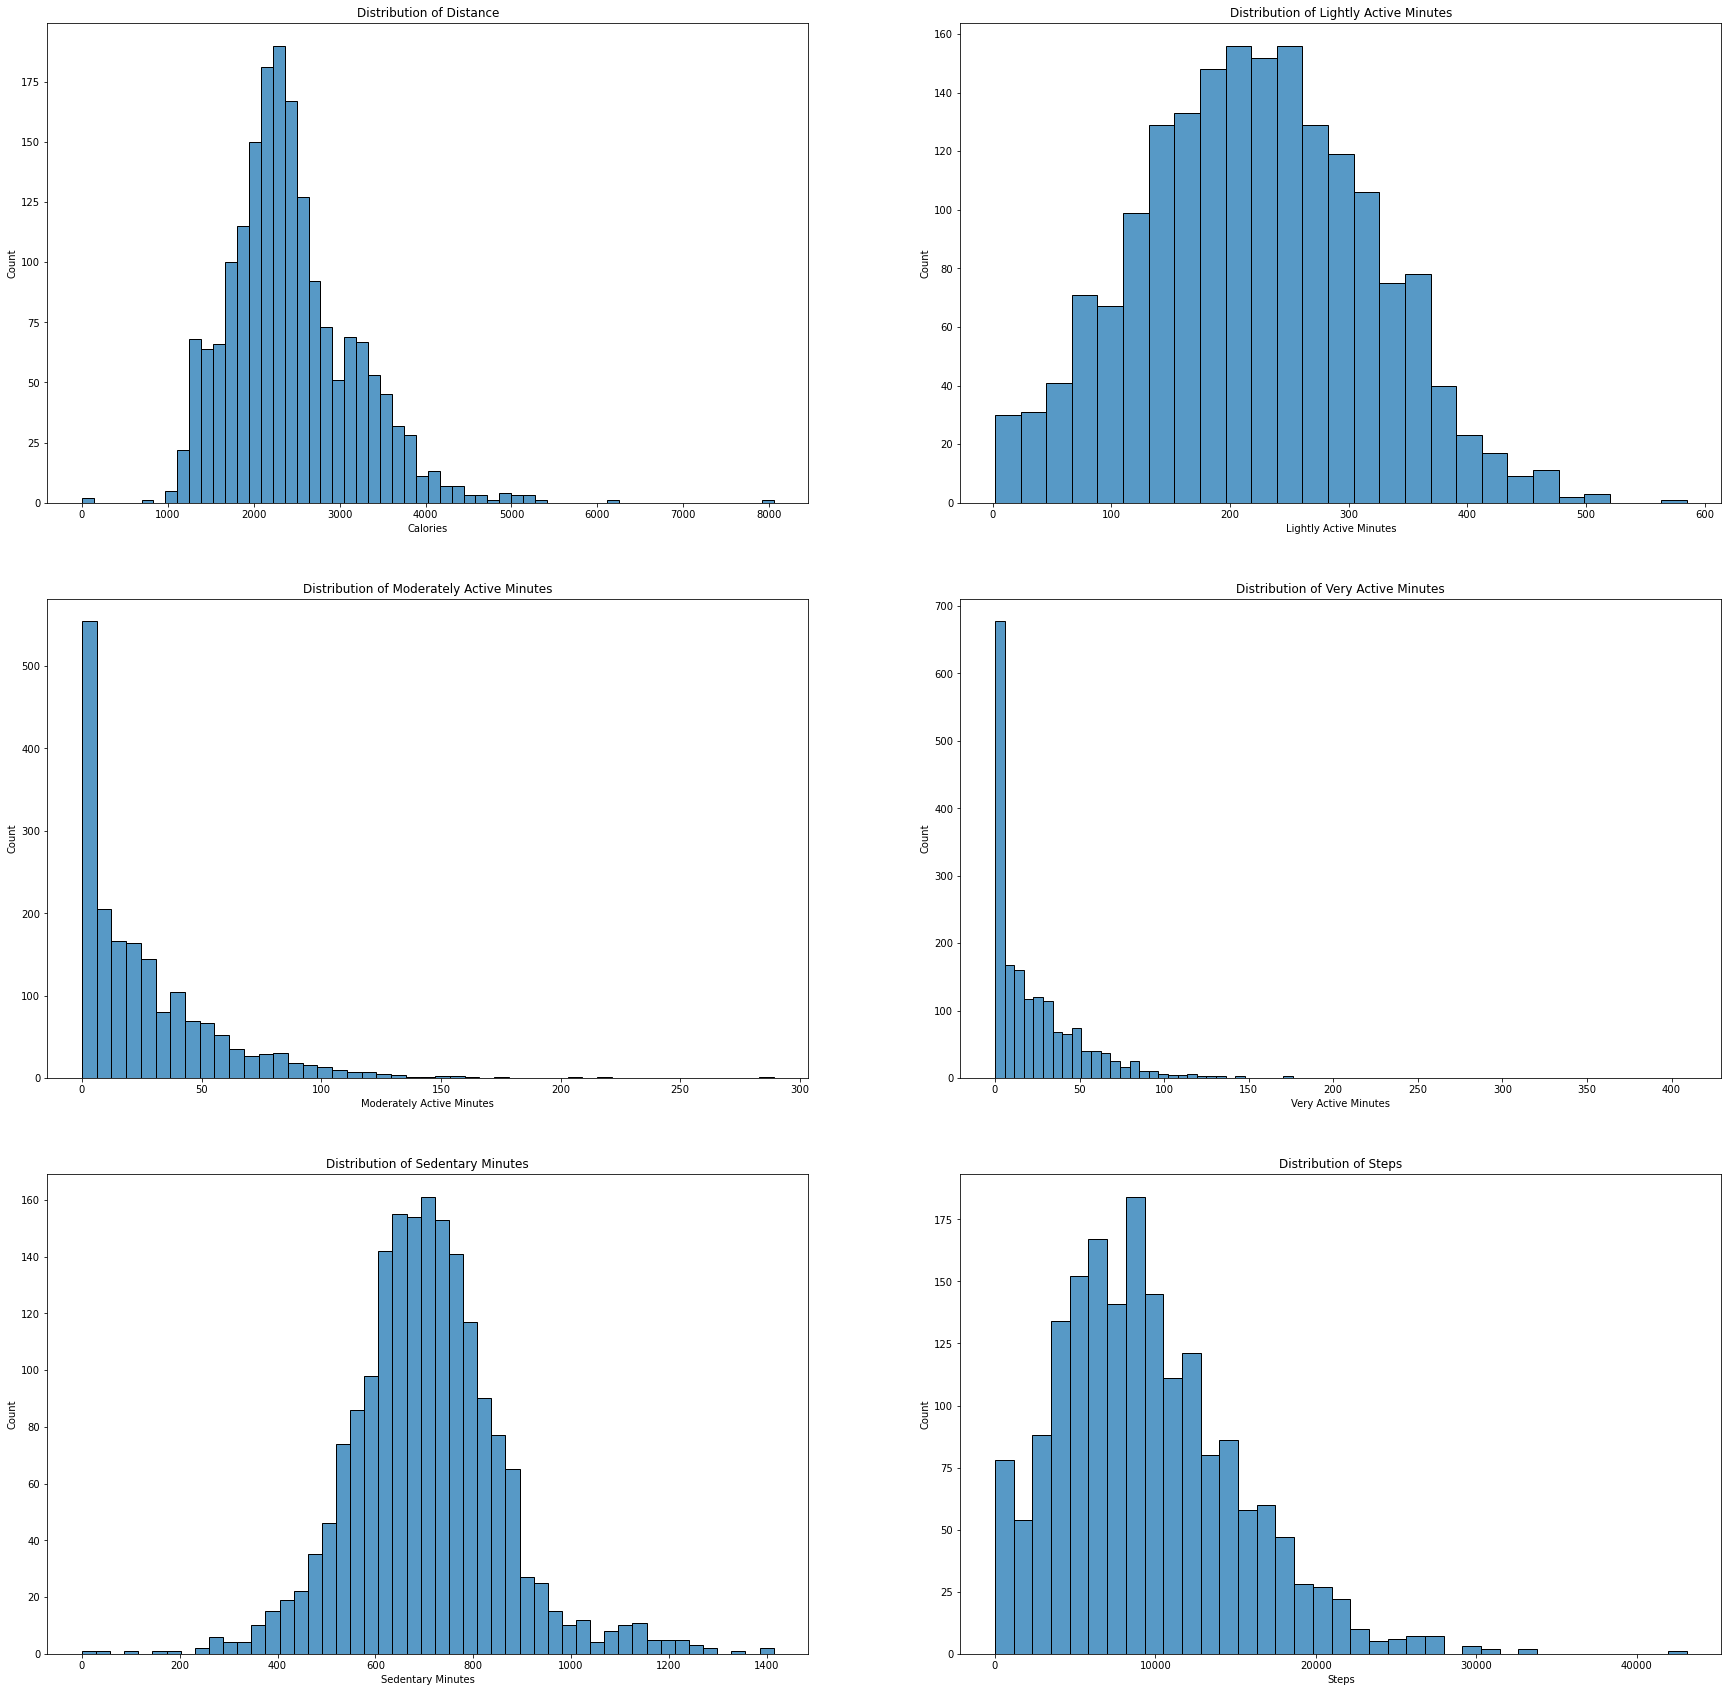

In [15]:
plt.figure(figsize=(30,30))
plt.subplot(3,2,1)
sns.histplot(data=features_df, x="calories")
plt.xlabel("Calories")
plt.title("Distribution of Calories")
plt.title("Distribution of Distance")
plt.subplot(3,2,2)
sns.histplot(data=features_df, x="lightly_active_minutes")
plt.xlabel("Lightly Active Minutes")
plt.title("Distribution of Lightly Active Minutes")
plt.subplot(3,2,3)
sns.histplot(data=features_df, x="moderately_active_minutes")
plt.xlabel("Moderately Active Minutes")
plt.title("Distribution of Moderately Active Minutes")
plt.subplot(3,2,4)
sns.histplot(data=features_df, x="very_active_minutes")
plt.xlabel("Very Active Minutes")
plt.title("Distribution of Very Active Minutes")
plt.subplot(3,2,5)
sns.histplot(data=features_df, x="sedentary_minutes")
plt.xlabel("Sedentary Minutes")
plt.title("Distribution of Sedentary Minutes")
plt.subplot(3,2,6)
sns.histplot(data=features_df, x="steps")
plt.xlabel("Steps")
plt.title("Distribution of Steps")

In [16]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
features_df_out = features_df[~((features_df < (Q1 - 1.5 * IQR)) |(features_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(features_df_out.shape)

(1358, 10)


In [17]:
features_df_1 = features_df
features_df = features_df_out

Text(0.5, 1.0, 'Distribution of Steps')

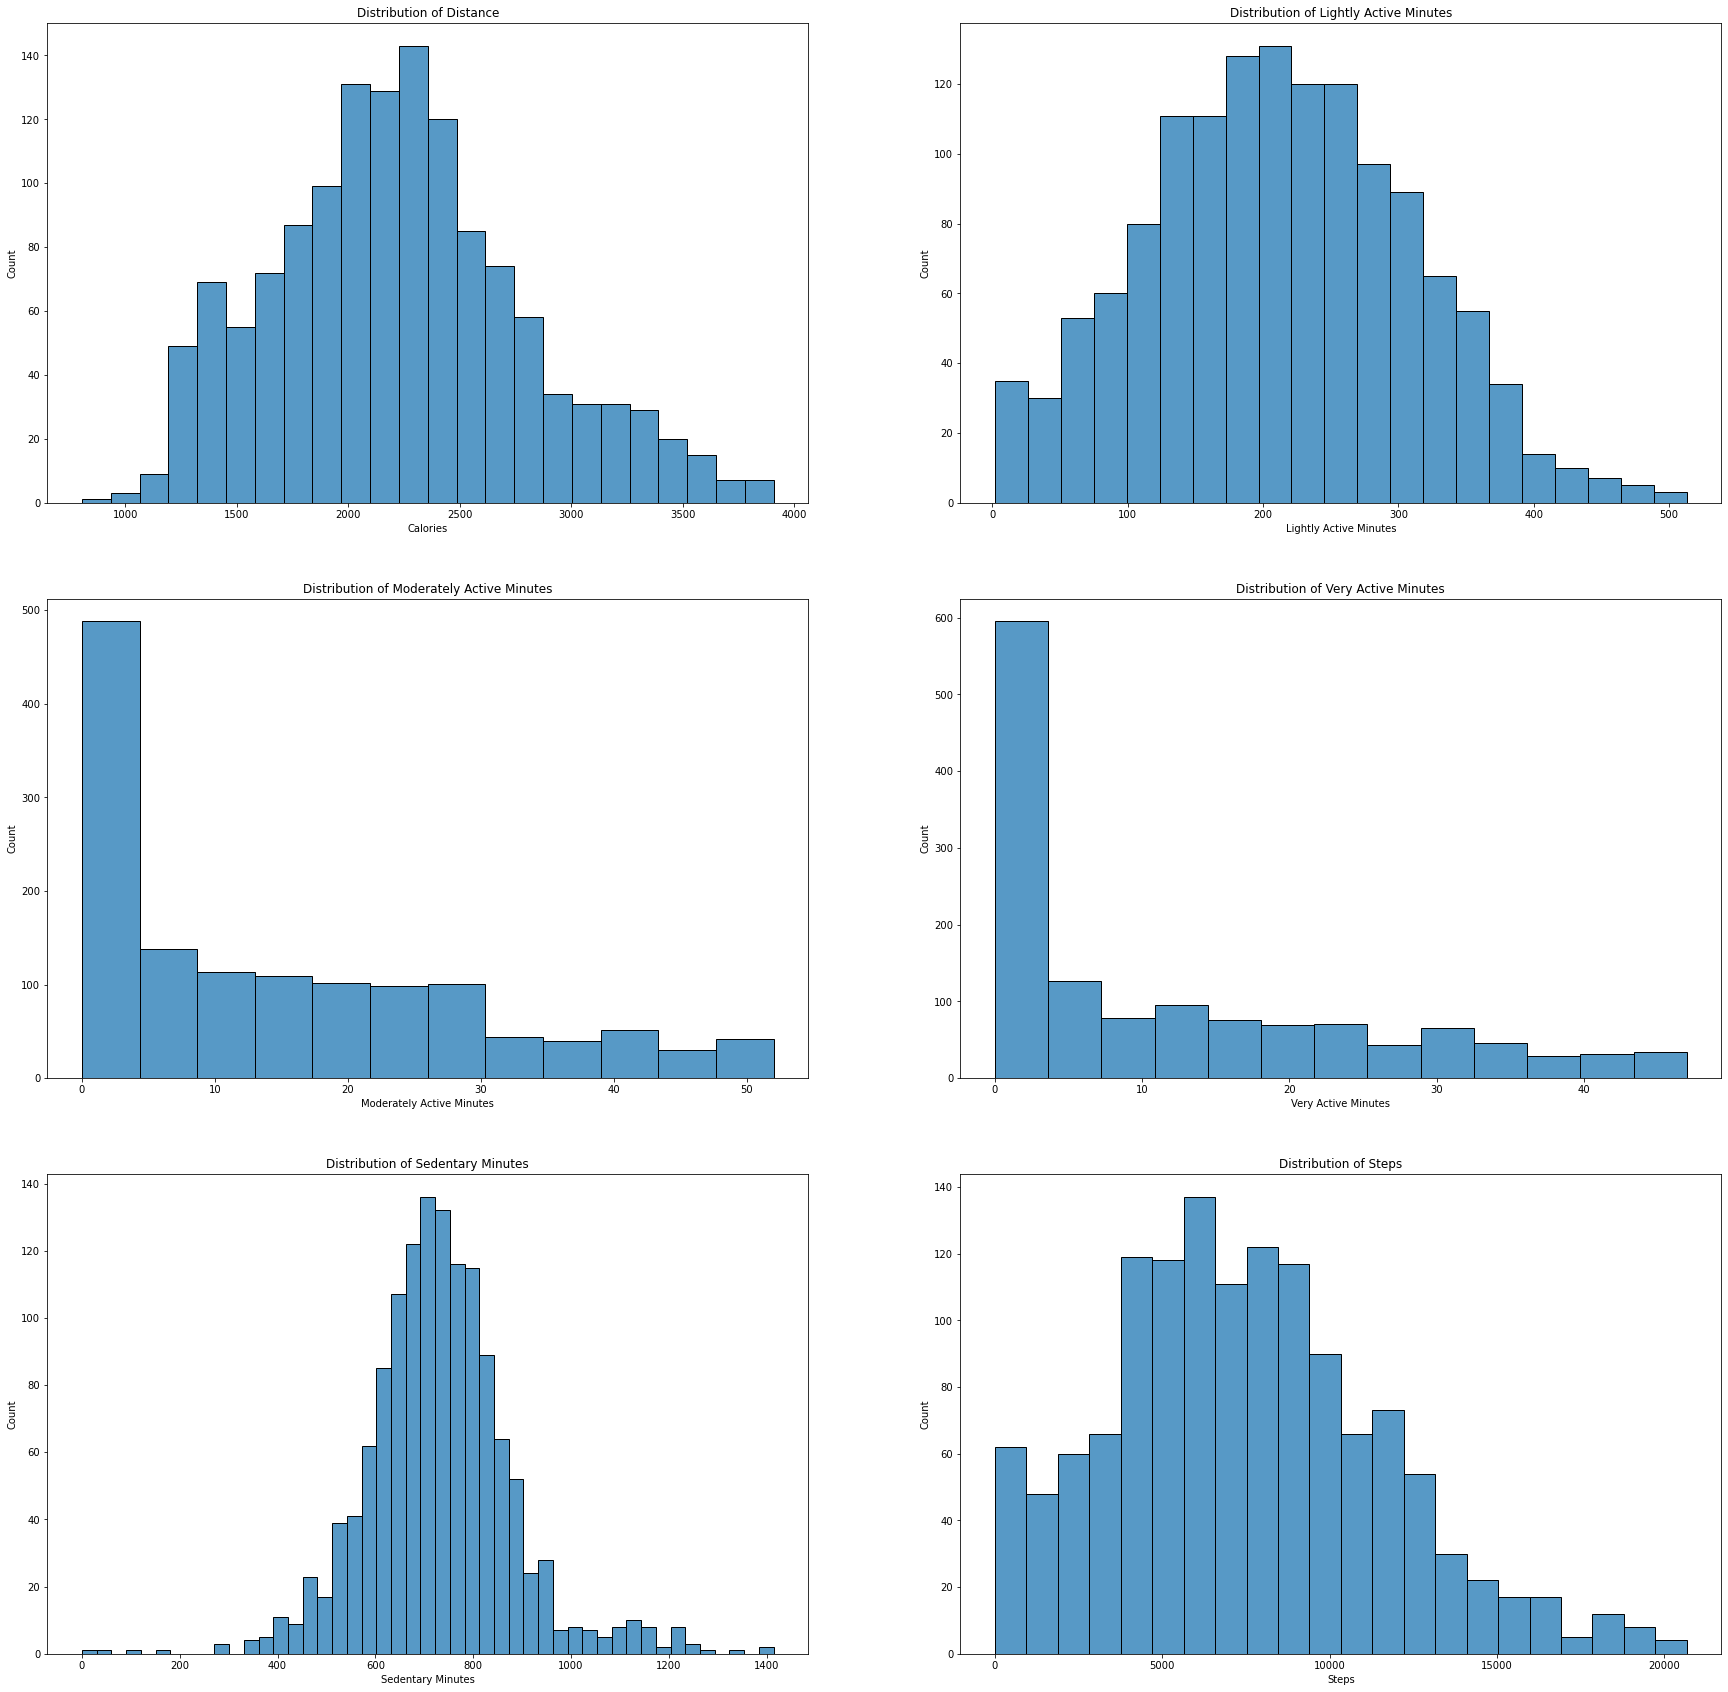

In [18]:
plt.figure(figsize=(30,30))
plt.subplot(3,2,1)
sns.histplot(data=features_df_out, x="calories")
plt.xlabel("Calories")
plt.title("Distribution of Calories")
plt.title("Distribution of Distance")
plt.subplot(3,2,2)
sns.histplot(data=features_df_out, x="lightly_active_minutes")
plt.xlabel("Lightly Active Minutes")
plt.title("Distribution of Lightly Active Minutes")
plt.subplot(3,2,3)
sns.histplot(data=features_df_out, x="moderately_active_minutes")
plt.xlabel("Moderately Active Minutes")
plt.title("Distribution of Moderately Active Minutes")
plt.subplot(3,2,4)
sns.histplot(data=features_df_out, x="very_active_minutes")
plt.xlabel("Very Active Minutes")
plt.title("Distribution of Very Active Minutes")
plt.subplot(3,2,5)
sns.histplot(data=features_df_out, x="sedentary_minutes")
plt.xlabel("Sedentary Minutes")
plt.title("Distribution of Sedentary Minutes")
plt.subplot(3,2,6)
sns.histplot(data=features_df_out, x="steps")
plt.xlabel("Steps")
plt.title("Distribution of Steps")

In [19]:
print(features_df.isnull().sum())

calories                     0
steps                        0
age                          0
lightly_active_minutes       0
moderately_active_minutes    0
very_active_minutes          0
sedentary_minutes            0
gender                       0
bmi                          0
sleep_score                  0
dtype: int64


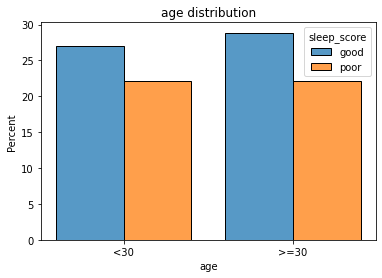

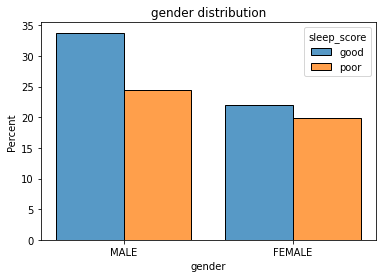

In [20]:
cat_features = ['age', 'gender']
target_col = 'sleep_score'

# features_df['bmi'] = pd.Categorical(features_df['bmi'], ['<19','19.0','20.0','21.0','22.0','23.0','24.0','>=25','26.0','29.0','>=30'])
# Loop through each categorical feature and plot side-by-side bar chart
for col in cat_features:
    sns.histplot(data=features_df, x=col, hue=target_col, stat='percent', multiple="dodge", shrink=.8).set( title=(col+' distribution'))
    plt.show()

good    758
poor    600
Name: sleep_score, dtype: int64


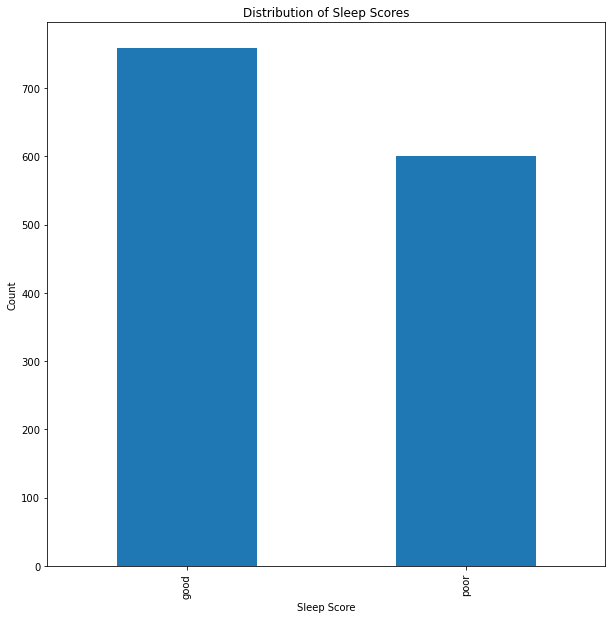

In [21]:
plt.figure(figsize=(10,10))
features_df["sleep_score"].value_counts().plot(kind='bar')
plt.xlabel("Sleep Score")
plt.ylabel("Count")
plt.title("Distribution of Sleep Scores")
print(features_df["sleep_score"].value_counts())

In [22]:
features_df

,calories,steps,age,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,gender,bmi,sleep_score
0,2351.59,8833.0,<30,149.0,24.0,33.0,713.0,MALE,<19,good
1,2332.08,9727.0,<30,132.0,25.0,31.0,704.0,MALE,<19,good
2,2262.30,8253.0,<30,112.0,27.0,31.0,710.0,MALE,<19,good
3,2325.10,9015.0,<30,133.0,21.0,37.0,622.0,MALE,<19,good
6,1968.24,3796.0,<30,113.0,9.0,0.0,763.0,MALE,<19,good
...,...,...,...,...,...,...,...,...,...,...
7375,2344.01,13554.0,<30,342.0,26.0,31.0,581.0,FEMALE,23,good
7376,2239.31,13638.0,<30,355.0,19.0,2.0,668.0,FEMALE,23,good
7377,1768.30,5366.0,<30,182.0,16.0,3.0,766.0,FEMALE,23,good
7378,2108.29,10448.0,<30,266.0,23.0,20.0,667.0,FEMALE,23,good


# ------- BEGIN MODELING -------

## Scaling and One-hot Encoding

In [23]:
# separate target variable from features
X = features_df.drop('sleep_score', axis=1)
y = features_df['sleep_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate the numerical features
numerical_features = X_train.select_dtypes(include=["float64", "int64"]).columns

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Encode categorical variables using one-hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Sampling

In [24]:
# using RandomOverSampler to oversample minority class
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# using SMOTE to oversample minority class
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# KNN

In [25]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Define the hyperparameters to tune
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 9]
}

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=10, scoring='precision')

In [26]:
regular = grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
knn_regular = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = knn_regular.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

knn_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       143
           1       0.67      0.57      0.61       129

    accuracy                           0.66       272
   macro avg       0.66      0.66      0.66       272
weighted avg       0.66      0.66      0.66       272

Accuracy: 0.662
Precision: 0.670
Recall: 0.566
F1 Score: 0.613
ROC AUC Score: 0.657
AP Score: 0.585
Confusion Matrix:
[[107  36]
 [ 56  73]]


## Oversampling + Hyperparameter Tuning

In [27]:
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# do we want average = binary, weighted, macro, micro?
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

knn_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'n_neighbors': 9}
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       143
           1       0.66      0.63      0.64       129

    accuracy                           0.67       272
   macro avg       0.67      0.67      0.67       272
weighted avg       0.67      0.67      0.67       272

Accuracy: 0.669
Precision: 0.659
Recall: 0.628
F1 Score: 0.643
ROC AUC Score: 0.667
AP Score: 0.590
Confusion Matrix:
[[101  42]
 [ 48  81]]


## SMOTE + Hyperparameter Tuning

In [28]:
grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

knn_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'n_neighbors': 9}
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       143
           1       0.69      0.66      0.67       129

    accuracy                           0.69       272
   macro avg       0.69      0.69      0.69       272
weighted avg       0.69      0.69      0.69       272

Accuracy: 0.695
Precision: 0.685
Recall: 0.659
F1 Score: 0.672
ROC AUC Score: 0.693
AP Score: 0.613
Confusion Matrix:
[[104  39]
 [ 44  85]]


## Balanced Weights

In [29]:
# Create a KNN classifier
knn = KNeighborsClassifier(weights="distance")

# Define the hyperparameters to tune
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 9],
}

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=10, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# do we want average = binary, weighted, macro, micro?
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

knn_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'n_neighbors': 9}
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       143
           1       0.71      0.56      0.62       129

    accuracy                           0.68       272
   macro avg       0.69      0.67      0.67       272
weighted avg       0.68      0.68      0.68       272

Accuracy: 0.680
Precision: 0.706
Recall: 0.558
F1 Score: 0.623
ROC AUC Score: 0.674
AP Score: 0.604
Confusion Matrix:
[[113  30]
 [ 57  72]]


# Decision Trees

In [30]:
# train Decision Tree classifier
dtc = DecisionTreeClassifier(random_state=42)

# Set the parameters for grid search
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [1, 2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(dtc, param_grid, cv=5, n_jobs=-1, scoring='precision')

In [31]:
regular = grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
dtc_regular_model = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = dtc_regular_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dt_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       143
           1       0.93      0.10      0.18       129

    accuracy                           0.57       272
   macro avg       0.74      0.55      0.45       272
weighted avg       0.73      0.57      0.46       272

Accuracy: 0.570
Precision: 0.929
Recall: 0.101
F1 Score: 0.182
ROC AUC Score: 0.547
AP Score: 0.520
Confusion Matrix:
[[142   1]
 [116  13]]


## Oversampling

In [32]:
oversample = grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best hyperparameters:", oversample.best_params_)
dtc_oversample = oversample.best_estimator_

# evaluate performance on test set with oversampling
y_pred = dtc_oversample.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dt_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       143
           1       0.94      0.12      0.21       129

    accuracy                           0.58       272
   macro avg       0.75      0.55      0.46       272
weighted avg       0.74      0.58      0.47       272

Accuracy: 0.577
Precision: 0.938
Recall: 0.116
F1 Score: 0.207
ROC AUC Score: 0.555
AP Score: 0.528
Confusion Matrix:
[[142   1]
 [114  15]]


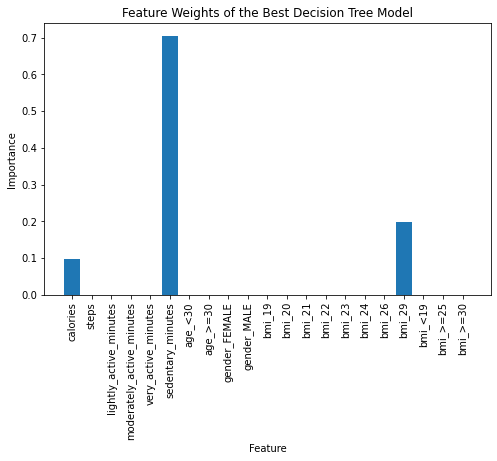

In [33]:
# Extract feature importances
importances = dtc_oversample.feature_importances_

# Plot the feature importances
plt.subplots(figsize=(8,5))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Weights of the Best Decision Tree Model")
plt.show()

## SMOTE

In [34]:
smote = grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters
print("Best hyperparameters:", smote.best_params_)
dtc_smote = smote.best_estimator_

# evaluate performance on test set with SMOTE
y_pred = dtc_smote.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dt_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       143
           1       0.93      0.10      0.18       129

    accuracy                           0.57       272
   macro avg       0.74      0.55      0.45       272
weighted avg       0.73      0.57      0.46       272

Accuracy: 0.570
Precision: 0.929
Recall: 0.101
F1 Score: 0.182
ROC AUC Score: 0.547
AP Score: 0.520
Confusion Matrix:
[[142   1]
 [116  13]]


## Balanced weights

In [35]:
# train Random Forest classifier with balanced class weights
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Set the parameters for grid search
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [1, 2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(dtc, param_grid, cv=5, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
dtc_best = grid_search.best_estimator_

# evaluate performance on test set
y_pred = dtc_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1, average='binary')
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dt_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       143
           1       0.93      0.10      0.18       129

    accuracy                           0.57       272
   macro avg       0.74      0.55      0.45       272
weighted avg       0.73      0.57      0.46       272

Accuracy: 0.570
Precision: 0.929
Recall: 0.101
F1 Score: 0.182
ROC AUC Score: 0.547
AP Score: 0.520
Confusion Matrix:
[[142   1]
 [116  13]]


# Random Forest

In [36]:
# train Random Forest classifier
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, scoring='precision')

In [37]:
regular = grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
rf_regular_model = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = rf_regular_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

rf_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.56      0.97      0.71       143
           1       0.81      0.17      0.28       129

    accuracy                           0.59       272
   macro avg       0.69      0.57      0.50       272
weighted avg       0.68      0.59      0.51       272

Accuracy: 0.588
Precision: 0.815
Recall: 0.171
F1 Score: 0.282
ROC AUC Score: 0.568
AP Score: 0.532
Confusion Matrix:
[[138   5]
 [107  22]]


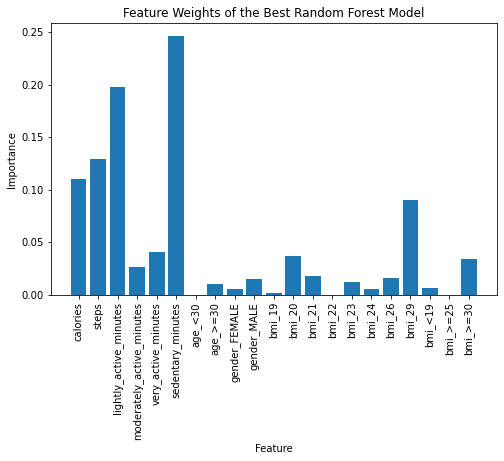

In [38]:
# Get the feature importances
importances = abs(rf_regular_model.feature_importances_)

# Plot the feature importances
plt.subplots(figsize=(8,5))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Weights of the Best Random Forest Model")
plt.show()

## Oversampling

In [39]:
oversample = grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best hyperparameters:", oversample.best_params_)
rfc_oversample = oversample.best_estimator_

# evaluate performance on test set with oversampling
y_pred = rfc_oversample.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

rf_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       143
           1       0.68      0.37      0.48       129

    accuracy                           0.62       272
   macro avg       0.64      0.61      0.59       272
weighted avg       0.63      0.62      0.59       272

Accuracy: 0.618
Precision: 0.676
Recall: 0.372
F1 Score: 0.480
ROC AUC Score: 0.606
AP Score: 0.549
Confusion Matrix:
[[120  23]
 [ 81  48]]


## SMOTE

In [40]:
smote = grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters
print("Best hyperparameters:", smote.best_params_)
rfc_smote = smote.best_estimator_

# evaluate performance on test set with SMOTE
y_pred = rfc_smote.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

rf_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       143
           1       0.67      0.32      0.43       129

    accuracy                           0.60       272
   macro avg       0.63      0.59      0.56       272
weighted avg       0.63      0.60      0.57       272

Accuracy: 0.603
Precision: 0.672
Recall: 0.318
F1 Score: 0.432
ROC AUC Score: 0.589
AP Score: 0.537
Confusion Matrix:
[[123  20]
 [ 88  41]]


## Balanced Weights

In [41]:
# train Random Forest classifier with balanced class weights
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
rfc_best = grid_search.best_estimator_

# evaluate performance on test set
y_pred = rfc_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1, average='binary')
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

rf_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.59      0.85      0.70       143
           1       0.68      0.36      0.47       129

    accuracy                           0.61       272
   macro avg       0.63      0.60      0.58       272
weighted avg       0.63      0.61      0.59       272

Accuracy: 0.614
Precision: 0.676
Recall: 0.357
F1 Score: 0.467
ROC AUC Score: 0.601
AP Score: 0.546
Confusion Matrix:
[[121  22]
 [ 83  46]]


# SVM

In [42]:
svm = SVC(random_state=42)
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}
grid_search_svm = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring='precision')

In [43]:
regular = grid_search_svm.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
svm_regular_model = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = svm_regular_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

svm_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

Best hyperparameters: {'C': 0.01, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.55      0.99      0.70       143
           1       0.92      0.09      0.16       129

    accuracy                           0.56       272
   macro avg       0.73      0.54      0.43       272
weighted avg       0.72      0.56      0.44       272

Accuracy: 0.562
Precision: 0.917
Recall: 0.085
F1 Score: 0.156
ROC AUC Score: 0.539
AP Score: 0.512
Confusion Matrix:
[[142   1]
 [118  11]]


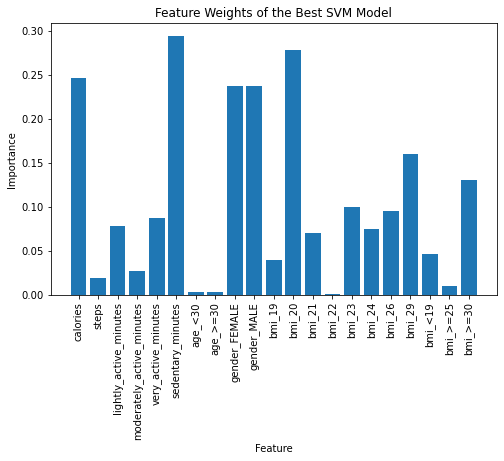

In [44]:
# Get the feature importances
importances = abs(svm_regular_model.coef_[0])

# Plot the feature importances
plt.subplots(figsize=(8,5))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Weights of the Best SVM Model")
plt.show()

## Random Oversampling

In [45]:
oversample = grid_search_svm.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best hyperparameters:", oversample.best_params_)
svm_oversample = oversample.best_estimator_

# evaluate performance on test set with oversampling
y_pred = svm_oversample.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

svm_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'C': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.59      0.87      0.70       143
           1       0.69      0.33      0.45       129

    accuracy                           0.61       272
   macro avg       0.64      0.60      0.58       272
weighted avg       0.64      0.61      0.58       272

Accuracy: 0.614
Precision: 0.694
Recall: 0.333
F1 Score: 0.450
ROC AUC Score: 0.600
AP Score: 0.547
Confusion Matrix:
[[124  19]
 [ 86  43]]


## SMOTE

In [46]:
smote = grid_search_svm.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters
print("Best hyperparameters:", smote.best_params_)
svm_smote = smote.best_estimator_

# evaluate performance on test set with SMOTE
y_pred = svm_smote.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

svm_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       143
           1       0.68      0.60      0.63       129

    accuracy                           0.67       272
   macro avg       0.67      0.67      0.67       272
weighted avg       0.67      0.67      0.67       272

Accuracy: 0.673
Precision: 0.675
Recall: 0.597
F1 Score: 0.634
ROC AUC Score: 0.669
AP Score: 0.594
Confusion Matrix:
[[106  37]
 [ 52  77]]


## Balanced Weights

In [47]:
# train SVM classifier with balanced class weights
svm = SVC(random_state=42, class_weight='balanced')
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
svm_best = grid_search.best_estimator_

# evaluate performance on test set
y_pred = svm_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

svm_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

Best hyperparameters: {'C': 0.001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       143
           1       0.72      0.18      0.29       129

    accuracy                           0.58       272
   macro avg       0.64      0.56      0.49       272
weighted avg       0.63      0.58      0.50       272

Accuracy: 0.577
Precision: 0.719
Recall: 0.178
F1 Score: 0.286
ROC AUC Score: 0.558
AP Score: 0.518
Confusion Matrix:
[[134   9]
 [106  23]]


# Logistic Regression

In [48]:
# define parameter grid for grid search
lr = LogisticRegression(random_state=42)

param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# perform grid search
grid = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='precision')

In [49]:
regular = grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
lr_regular_model = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = lr_regular_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

lr_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.58      0.96      0.72       143
           1       0.82      0.22      0.34       129

    accuracy                           0.61       272
   macro avg       0.70      0.59      0.53       272
weighted avg       0.69      0.61      0.54       272

Accuracy: 0.607
Precision: 0.824
Recall: 0.217
F1 Score: 0.344
ROC AUC Score: 0.588
AP Score: 0.550
Confusion Matrix:
[[137   6]
 [101  28]]


/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3

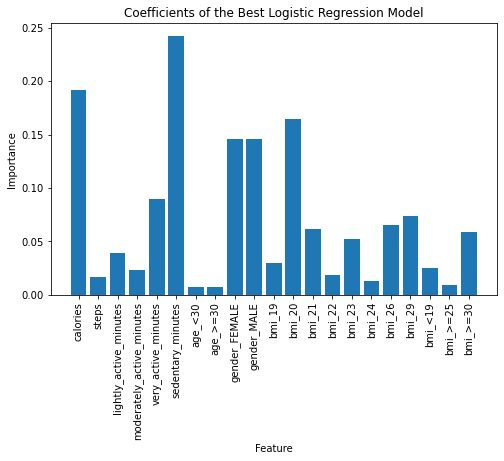

In [50]:
# Get the feature importances
importances = abs(lr_regular_model.coef_[0])

# Plot the feature importances
plt.subplots(figsize=(8,5))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Coefficients of the Best Logistic Regression Model")
plt.show()

## Random Oversampling

In [51]:
grid.fit(X_train_oversampled, y_train_oversampled)

print("Best hyperparameters:", grid.best_params_)
lr_best = grid.best_estimator_

# evaluate performance on test set
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

lr_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3

Best hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       143
           1       0.62      0.58      0.60       129

    accuracy                           0.64       272
   macro avg       0.63      0.63      0.63       272
weighted avg       0.64      0.64      0.64       272

Accuracy: 0.636
Precision: 0.625
Recall: 0.581
F1 Score: 0.602
ROC AUC Score: 0.633
AP Score: 0.562
Confusion Matrix:
[[98 45]
 [54 75]]


/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## SMOTE

In [52]:
grid.fit(X_train_smote, y_train_smote)

print("Best hyperparameters:", grid.best_params_)
lr_best = grid.best_estimator_

# evaluate performance on test set
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

lr_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_s

Best hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       143
           1       0.65      0.60      0.62       129

    accuracy                           0.66       272
   macro avg       0.66      0.66      0.66       272
weighted avg       0.66      0.66      0.66       272

Accuracy: 0.658
Precision: 0.653
Recall: 0.597
F1 Score: 0.623
ROC AUC Score: 0.655
AP Score: 0.581
Confusion Matrix:
[[102  41]
 [ 52  77]]


## Balanced Weights

In [53]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
# define parameter grid for grid search
param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# perform grid search
grid = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='precision')
grid.fit(X_train, y_train)

print("Best hyperparameters:", grid.best_params_)
lr_best = grid.best_estimator_

# evaluate performance on test set
y_pred = lr_best.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

lr_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolelin/opt/anaconda3

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       143
           1       0.63      0.60      0.62       129

    accuracy                           0.64       272
   macro avg       0.64      0.64      0.64       272
weighted avg       0.64      0.64      0.64       272

Accuracy: 0.643
Precision: 0.629
Recall: 0.605
F1 Score: 0.617
ROC AUC Score: 0.641
AP Score: 0.568
Confusion Matrix:
[[97 46]
 [51 78]]


/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

# XGBoost

In [54]:
# XGBoost cannot have < in feature names, therefore replace with 'less_than_' in train and test data

# create a dictionary to map old column names to new column names
new_column_names = {}
for col in X_train.columns:
    new_col = col.replace('<', 'less_than_')
    new_column_names[col] = new_col

# rename the columns using the dictionary
X_train_renamed = X_train.rename(columns=new_column_names)
X_train_oversampled_renamed = X_train_oversampled.rename(columns=new_column_names)
X_train_smote_renamed = X_train_smote.rename(columns=new_column_names)
X_test_renamed = X_test.rename(columns=new_column_names)

In [55]:
# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the grid of hyperparameters to search over
param_grid = {
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

# perform grid search
grid = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='precision')

In [56]:
regular = grid.fit(X_train_renamed, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", regular.best_params_)
xgb_regular_model = regular.best_estimator_

# evaluate performance on test set with oversampling
y_pred = xgb_regular_model.predict(X_test_renamed)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

xgb_regular = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       143
           1       0.81      0.13      0.23       129

    accuracy                           0.57       272
   macro avg       0.68      0.55      0.47       272
weighted avg       0.68      0.57      0.48       272

Accuracy: 0.574
Precision: 0.810
Recall: 0.132
F1 Score: 0.227
ROC AUC Score: 0.552
AP Score: 0.518
Confusion Matrix:
[[139   4]
 [112  17]]


## Random Oversampling

In [57]:
ro = grid.fit(X_train_oversampled_renamed, y_train_oversampled)

print("Best hyperparameters:", grid.best_params_)
xgb_best = ro.best_estimator_

# evaluate performance on test set
y_pred = xgb_best.predict(X_test_renamed)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

xgb_over = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.57      0.90      0.70       143
           1       0.68      0.23      0.35       129

    accuracy                           0.58       272
   macro avg       0.62      0.57      0.52       272
weighted avg       0.62      0.58      0.53       272

Accuracy: 0.585
Precision: 0.682
Recall: 0.233
F1 Score: 0.347
ROC AUC Score: 0.567
AP Score: 0.523
Confusion Matrix:
[[129  14]
 [ 99  30]]


## SMOTE

In [58]:
smote = grid.fit(X_train_smote_renamed, y_train_smote)

print("Best hyperparameters:", grid.best_params_)
xgb_best = smote.best_estimator_

# evaluate performance on test set
y_pred = xgb_best.predict(X_test_renamed)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

xgb_smote = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.56      0.92      0.70       143
           1       0.70      0.20      0.31       129

    accuracy                           0.58       272
   macro avg       0.63      0.56      0.51       272
weighted avg       0.63      0.58      0.52       272

Accuracy: 0.581
Precision: 0.703
Recall: 0.202
F1 Score: 0.313
ROC AUC Score: 0.562
AP Score: 0.520
Confusion Matrix:
[[132  11]
 [103  26]]


## Balanced

In [59]:
# Define the XGBoost classifier
pos_samples = sum(y_train == 1)
neg_samples = sum(y_train == 0)
# calculate the scale_pos_weight parameter
scale_pos_weight = neg_samples / pos_samples

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Define the grid of hyperparameters to search over
param_grid = {
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

# perform grid search
grid = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='precision')
grid.fit(X_train_renamed, y_train)

print("Best hyperparameters:", grid.best_params_)
xgb_best = grid.best_estimator_

# evaluate performance on test set
y_pred = xgb_best.predict(X_test_renamed)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

xgb_balance = [accuracy, precision, f1, roc_auc, ap]

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('ROC AUC Score: {:.3f}'.format(roc_auc))
print('AP Score: {:.3f}'.format(ap))
print('Confusion Matrix:\n{}'.format(cm))

Best hyperparameters: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       143
           1       0.93      0.11      0.19       129

    accuracy                           0.57       272
   macro avg       0.74      0.55      0.45       272
weighted avg       0.73      0.57      0.47       272

Accuracy: 0.574
Precision: 0.933
Recall: 0.109
F1 Score: 0.194
ROC AUC Score: 0.551
AP Score: 0.524
Confusion Matrix:
[[142   1]
 [115  14]]


# EDA -----------------------------------------------------------------------------------

# Results

We obeserve that the feature with the highest importance is sedentary minutes. When plotting out its distribution across both classes "good sleep" and "poor sleep," we see that there are no distinct distributions meaning that though sedentary minutes is important in determining sleep quality, one cannot say that sedentary minutes is a cause for either "good sleep" or "poor sleep"

<AxesSubplot:xlabel='sedentary_minutes', ylabel='Count'>

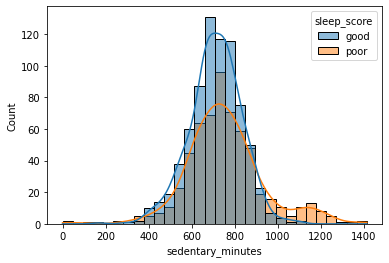

In [60]:
# Create histograms for the feature values for the positive and negative classes
sns.histplot(data=features_df, x='sedentary_minutes', hue='sleep_score', bins=30, kde=True)

## Sampling-specific

### No Sampling

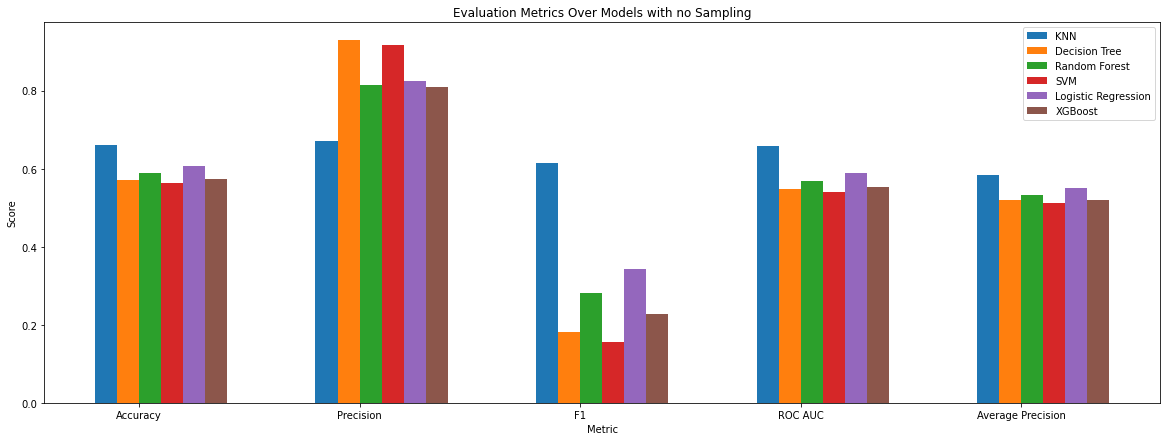

In [61]:
x = np.array([4,8,12,16,20])
width = 0.4

f, ax = plt.subplots(figsize=(20,7))

# plot data in grouped manner of bar type
plt.bar(x-width*3/2, knn_regular, width, label="KNN")
plt.bar(x-width/2, dt_regular, width, label="Decision Tree")
plt.bar(x+width/2, rf_regular, width, label="Random Forest")
plt.bar(x+width*3/2, svm_regular, width, label="SVM")
plt.bar(x+width*5/2, lr_regular, width, label="Logistic Regression")
plt.bar(x+width*7/2, xgb_regular, width, label="XGBoost")
plt.title("Evaluation Metrics Over Models with no Sampling")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend()
plt.show()

### Oversample

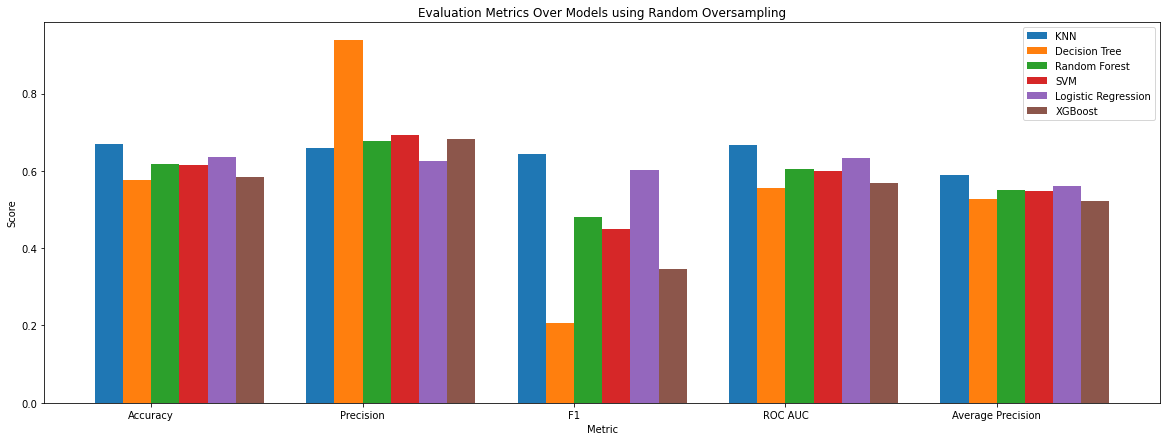

In [62]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-width*3/2, knn_over, width, label="KNN")
plt.bar(x-width/2, dt_over, width, label="Decision Tree")
plt.bar(x+width/2, rf_over, width, label="Random Forest")
plt.bar(x+width*3/2, svm_over, width, label="SVM")
plt.bar(x+width*5/2, lr_over, width, label="Logistic Regression")
plt.bar(x+width*7/2, xgb_over, width, label="XGBoost")
plt.title("Evaluation Metrics Over Models using Random Oversampling")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend()
plt.show()

### SMOTE

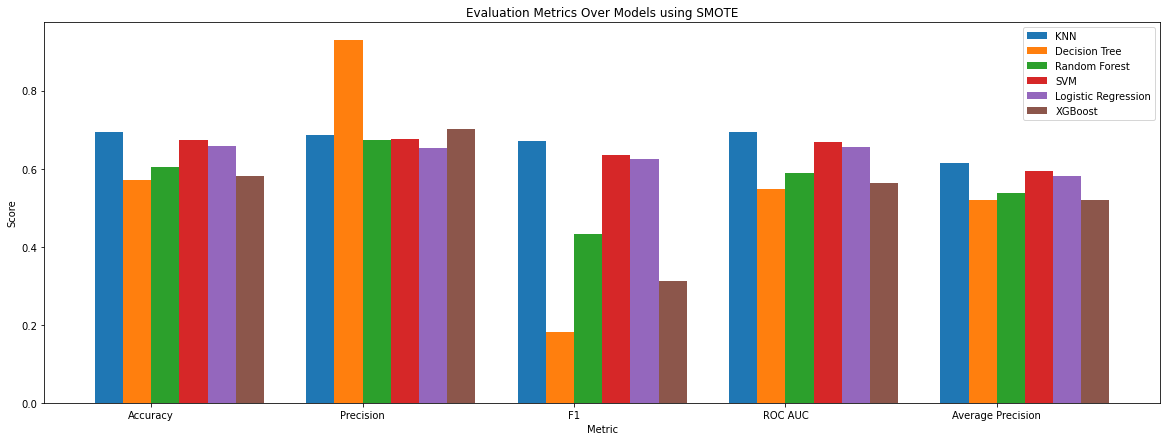

In [63]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-width*3/2, knn_smote, width, label="KNN")
plt.bar(x-width/2, dt_smote, width, label="Decision Tree")
plt.bar(x+width/2, rf_smote, width, label="Random Forest")
plt.bar(x+width*3/2, svm_smote, width, label="SVM")
plt.bar(x+width*5/2, lr_smote, width, label="Logistic Regression")
plt.bar(x+width*7/2, xgb_smote, width, label="XGBoost")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.title("Evaluation Metrics Over Models using SMOTE")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend()
plt.show()

### Balanced

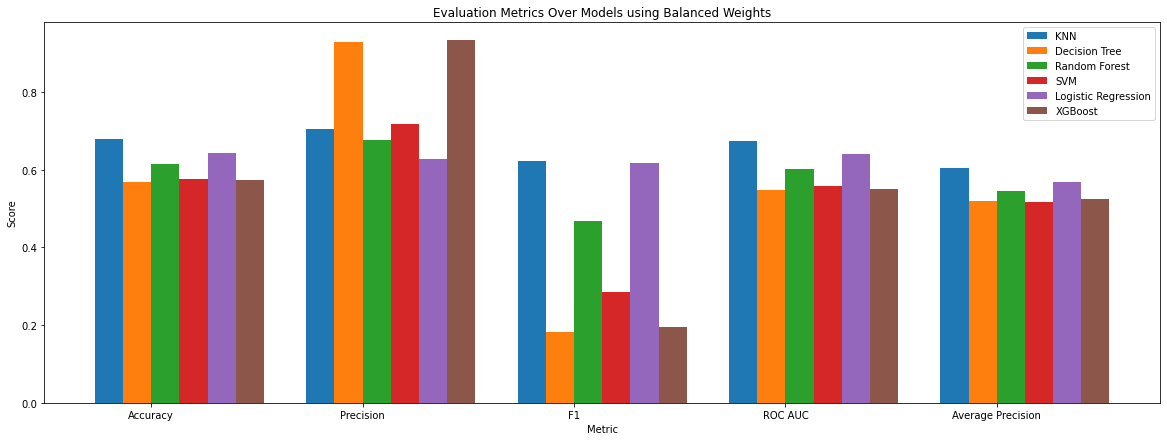

In [64]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-width*3/2, knn_balance, width, label="KNN")
plt.bar(x-width/2, dt_balance, width, label="Decision Tree")
plt.bar(x+width/2, rf_balance, width, label="Random Forest")
plt.bar(x+width*3/2, svm_balance, width, label="SVM")
plt.bar(x+width*5/2, lr_balance, width, label="Logistic Regression")
plt.bar(x+width*7/2, xgb_balance, width, label="XGBoost")
plt.title("Evaluation Metrics Over Models using Balanced Weights")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend()
plt.show()

## Some Selected Model-specific Plots (KNN, Random Forest, SVM, Logistic, XGBoost)

### KNN

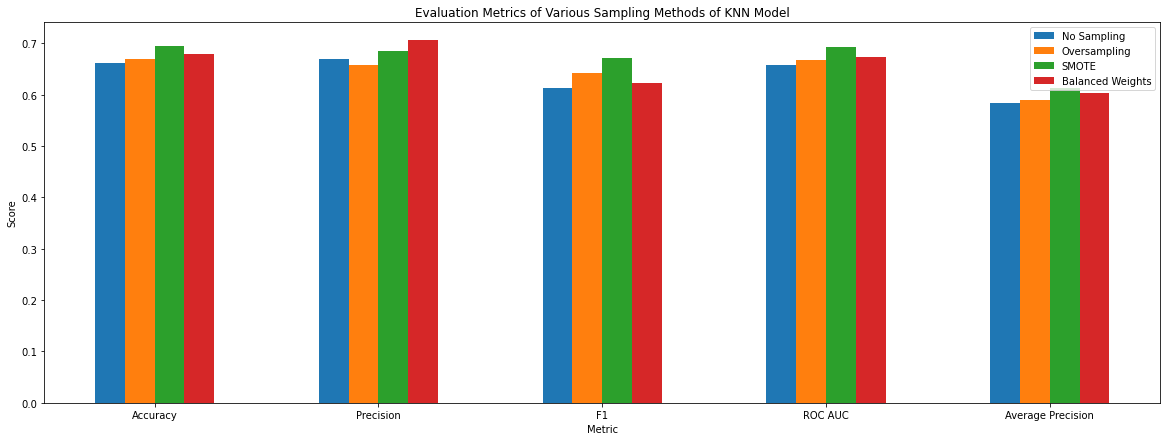

In [65]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-0.6, knn_regular, width)
plt.bar(x-0.2, knn_over, width)
plt.bar(x+0.2, knn_smote, width)
plt.bar(x+0.6, knn_balance, width)
plt.title("Evaluation Metrics of Various Sampling Methods of KNN Model")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(["No Sampling", "Oversampling", "SMOTE", "Balanced Weights"])
plt.show()

### Random Forest

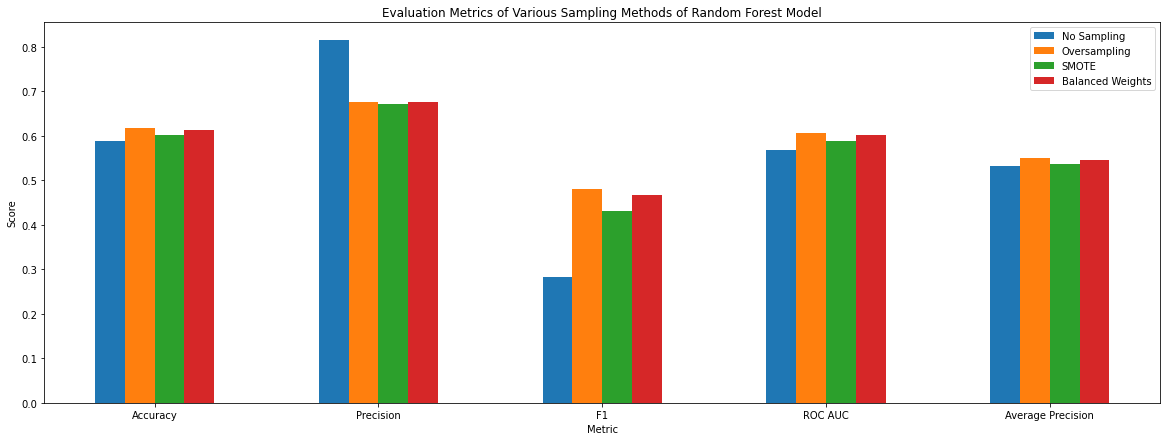

In [66]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-0.6, rf_regular, width)
plt.bar(x-0.2, rf_over, width)
plt.bar(x+0.2, rf_smote, width)
plt.bar(x+0.6, rf_balance, width)
plt.title("Evaluation Metrics of Various Sampling Methods of Random Forest Model")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(["No Sampling", "Oversampling", "SMOTE", "Balanced Weights"])
plt.show()

### SVM

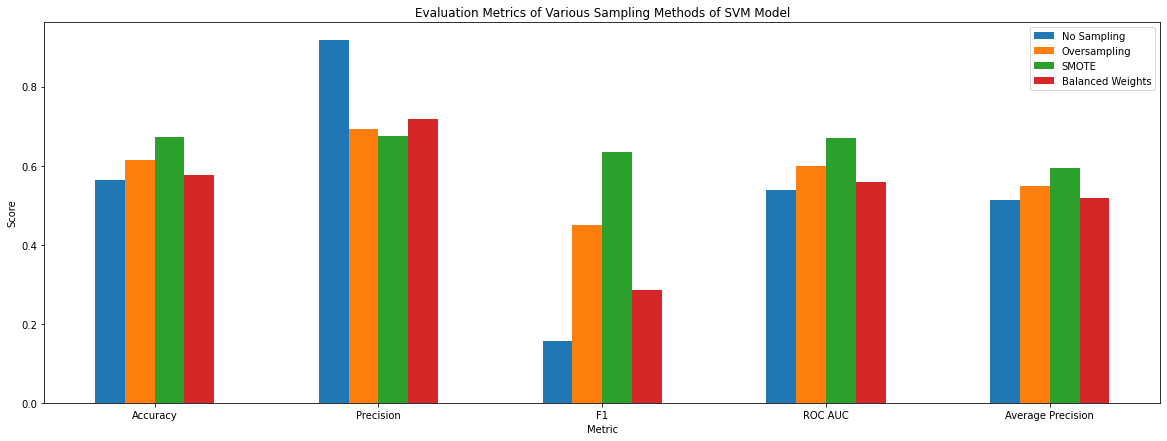

In [67]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-0.6, svm_regular, width)
plt.bar(x-0.2, svm_over, width)
plt.bar(x+0.2, svm_smote, width)
plt.bar(x+0.6, svm_balance, width)
plt.title("Evaluation Metrics of Various Sampling Methods of SVM Model")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(["No Sampling", "Oversampling", "SMOTE", "Balanced Weights"])
plt.show()

### Logistic

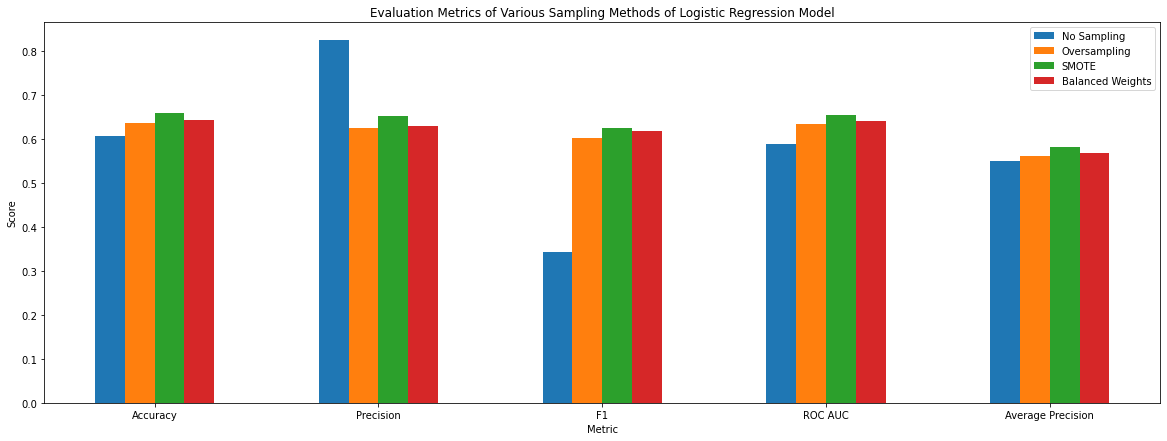

In [68]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-0.6, lr_regular, width)
plt.bar(x-0.2, lr_over, width)
plt.bar(x+0.2, lr_smote, width)
plt.bar(x+0.6, lr_balance, width)
plt.title("Evaluation Metrics of Various Sampling Methods of Logistic Regression Model")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(["No Sampling", "Oversampling", "SMOTE", "Balanced Weights"])
plt.show()

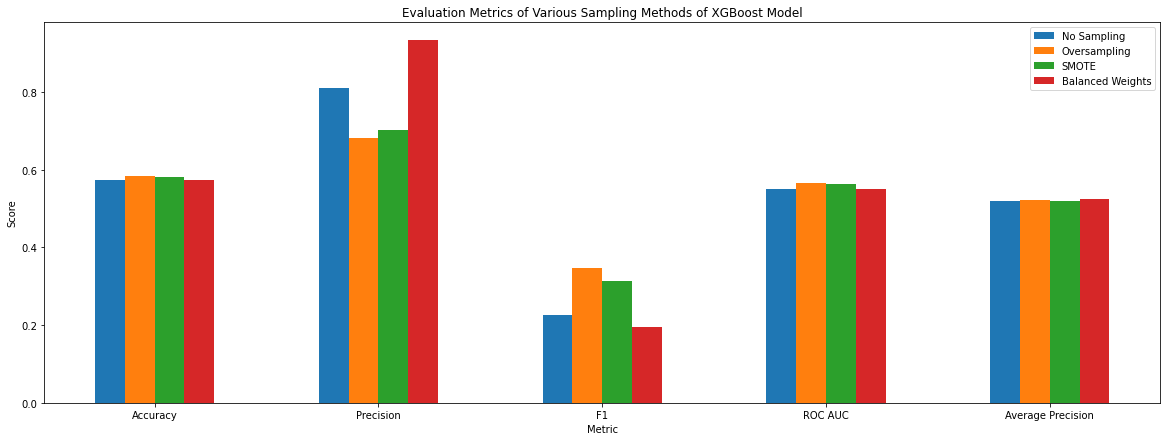

In [69]:
x = np.array([3,6,9,12,15])
width=0.4

f, ax = plt.subplots(figsize=(20,7))
  
# plot data in grouped manner of bar type
plt.bar(x-0.6, xgb_regular, width)
plt.bar(x-0.2, xgb_over, width)
plt.bar(x+0.2, xgb_smote, width)
plt.bar(x+0.6, xgb_balance, width)
plt.title("Evaluation Metrics of Various Sampling Methods of XGBoost Model")
plt.xticks(x, ['Accuracy', 'Precision', 'F1', 'ROC AUC', 'Average Precision'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(["No Sampling", "Oversampling", "SMOTE", "Balanced Weights"])
plt.show()

# Best Models (maximize precision)

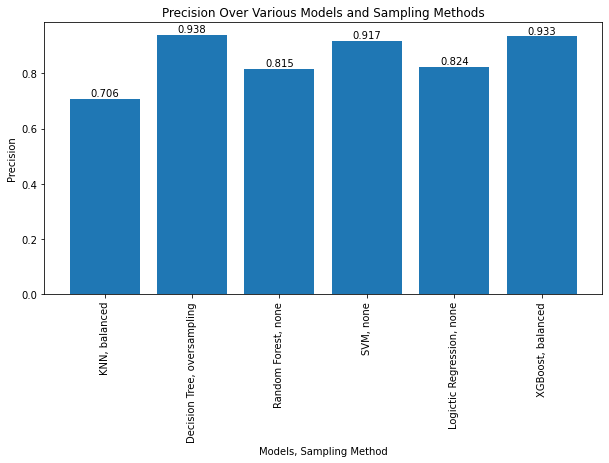

In [70]:
models = ['KNN, balanced', 'Decision Tree, oversampling', 'Random Forest, none', 'SVM, none', 'Logictic Regression, none', 'XGBoost, balanced']
precision = [knn_balance[1], dt_over[1], rf_regular[1], svm_regular[1], lr_regular[1], xgb_balance[1]]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, precision)
 
plt.xlabel("Models, Sampling Method")
plt.ylabel("Precision")
plt.title("Precision Over Various Models and Sampling Methods")
plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees

# adding text labels on top of the bars
for i, v in enumerate(precision):
    plt.text(i, v+0.01, str(round(v, 3)), ha='center')
    
plt.show()